In [171]:
import networkx as nx # graphs

In [172]:
import numpy as np
import sys
import itertools
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time 

In [173]:
def draw(V, E, i, flag):
    # fig, ax = plt.subplots()

    # Отображение ребер
    for edge in E:
        start = V[edge[0]]
        end = V[edge[1]]
        axs[i // 2, i % 2].plot([start[0], end[0]], [start[1], end[1]], color=('green' if flag else 'red'))
        
    # Отображение точек
    axs[i // 2, i % 2].scatter(V[:, 0], V[:, 1], color='blue')
    
    # Отображение графа
    # plt.show()

In [174]:
def list_to_edges(path):
    edges = []
    for i in range(len(path) - 1):
        edges.append((path[i], path[i + 1]))
    return edges

In [182]:
def christofides_serdjukov(graph):
    # Шаг 1: Построение минимального остовного дерева
    mst = nx.minimum_spanning_tree(graph)

    # Шаг 2: Поиск вершин с нечетной степенью в минимальном остовном дереве
    odd_degree_nodes = [node for node, degree in mst.degree() if degree % 2 == 1]

    # Шаг 3: Построение минимального паросочетания на подграфе, образованном вершинами с нечетной степенью
    odd_degree_subgraph = graph.subgraph(odd_degree_nodes)
    min_matching = nx.min_weight_matching(odd_degree_subgraph)
    
    # Шаг 4: Объединение минимального остовного дерева и минимального паросочетания
    eulerian_graph = nx.MultiGraph(mst)
    for edge in min_matching:
        eulerian_graph.add_edge(*edge)

    # Шаг 5: Построение эйлерова цикла в полученном графе
    eulerian_cycle = list(nx.eulerian_circuit(eulerian_graph))

    # Шаг 6: Удаление повторяющихся вершин
    visited = set()
    hampath = []
    for edge in eulerian_cycle:
        if edge[0] not in visited:
            visited.add(edge[0])
            hampath.append(edge[0])

    # Добавление последней вершины в путь
    hampath.append(eulerian_cycle[-1][1])
    
    edges = list_to_edges(hampath)
    opt = 0
    for e in edges:
        opt += graph.edges[e]['weight']
    
    return hampath, opt

In [183]:
def tsp_brute_force(graph):
    num_points = graph.number_of_nodes()
    min_distance = sys.maxsize
    min_path = []

    # Перебор всех возможных комбинаций вершин
    for path in itertools.permutations(range(num_points)):
        distance = 0
        for i in range(num_points - 1):
            distance += graph[path[i]][path[i+1]]['weight']

        # Добавление расстояния от последней вершины к первой
        distance += graph[path[-1]][path[0]]['weight']

        # Проверка на минимальное расстояние
        if distance < min_distance:
            min_distance = distance
            min_path = path
    
    min_path = list(min_path)
    min_path.append(min_path[0])
    
    return min_path, min_distance

In [200]:
def solve(V: np.array, i):
    augm = V[np.newaxis, :]
    dists = augm - augm.reshape((-1, 1, 2))

    Mat = norm(dists, axis=-1)

    G = nx.from_numpy_array(Mat)
    
    hampath, computed = christofides_serdjukov(G)
    path, opt = tsp_brute_force(G)
        
    # draw(V, list_to_edges(hampath), i, False)
    # draw(V, list_to_edges(path), i, True)
    # axs[i // 2, i % 2].set_title(f'Deviation: {computed / opt}')
    # print("deviation: ", computed / opt)
    return computed / opt

In [193]:
def generate_random_points_uniform(num_points, x_range, y_range):
    points = []
    for _ in range(num_points):
        x = np.random.uniform(0, x_range)
        y = np.random.uniform(0, y_range)
        points.append([x, y])
    return np.array(points)

In [194]:
def generate_random_points_gauss(num_points, num_clusters, cluster_std, x_range, y_range):
    mean = np.random.uniform(low=0, high=max(x_range, y_range), size=(num_clusters, 2))
    cov = np.diag([cluster_std] * 2)
    points = np.concatenate([np.random.multivariate_normal(m, cov, int(num_points / num_clusters)) for m in mean])

    points = np.clip(points, [0, 0], [x_range, y_range])

    return points

In [211]:
num_points = np.arange(2, 10, 1)
times_1 = []
cnt = 20
for points in num_points:
    mean_miss=0
    for i in range(cnt):
        V = generate_random_points_uniform(points, 20, 20)
        dev = solve(V, 0)
        mean_miss += dev
    mean_miss /= cnt
    print(points)
    times_1.append(mean_miss)

2
3
4
5
6
7
8
9


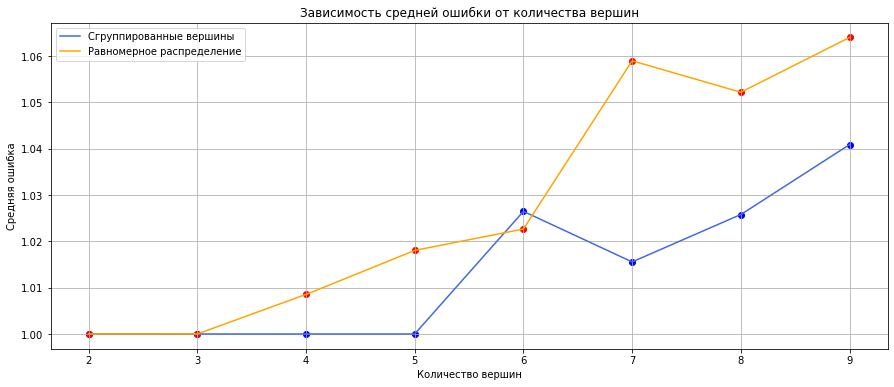

In [220]:
x_curve = np.linspace(min(num_points), max(num_points), 1000)
y_curve = np.interp(x_curve, num_points, times)
y_curve_1 = np.interp(x_curve, num_points, times_1)


# Построение графика
plt.figure( figsize=(15, 6))

plt.scatter(num_points, times, color='blue')
plt.plot(x_curve, y_curve, color='royalblue', label='Сгруппированные вершины')

plt.scatter(num_points, times_1, color='red')
plt.plot(x_curve, y_curve_1, color='orange', label='Равномерное распределение')

plt.xlabel('Количество вершин')
plt.ylabel('Средняя ошибка')
plt.title('Зависимость средней ошибки от количества вершин')
plt.grid(True)
plt.legend()
plt.savefig('graph3.png')
plt.show()

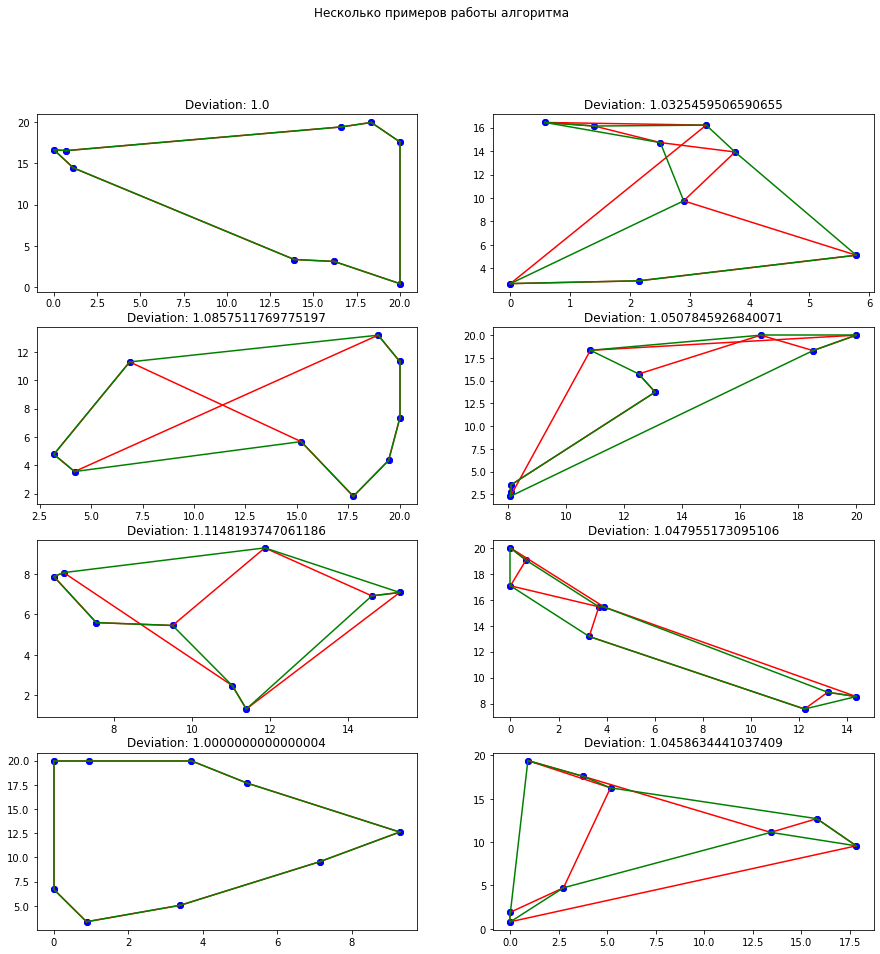

In [199]:
num_points = 10        # Количество точек
num_clusters = 3       # Количество кластеров
cluster_std = 4        # Стандартное отклонение кластеров
x_range = 20           # Диапазон значений по оси X
y_range = 20           # Диапазон значений по оси Y

V = generate_random_points_gauss(num_points, num_clusters, cluster_std, x_range, y_range)

fig, axs = plt.subplots(nrows=4 , ncols=2, figsize=(15, 15))
fig.suptitle('Несколько примеров работы алгоритма')

for i in range(8):
    V = generate_random_points_gauss(num_points, num_clusters, cluster_std, x_range, y_range)
    solve(V, i)
plt.savefig('samples_gauss.png')    
plt.show()